# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,3647.108330,1.0000,-131.886217,1462.17,1330.283783
OMUSDT,526.319895,1790.602202,0.4910,0.000000,1264.28,1264.280000
BTCUSDT,601.021649,817.245534,0.2241,3.537078,216.22,219.757078
SOLUSDT,281.200518,423.600933,0.1161,0.000000,142.40,142.400000
JASMYUSDT,387.458505,268.267151,0.0736,0.000000,-119.19,-119.190000
ETHUSDT,250.747339,214.613337,0.0588,0.000000,-36.13,-36.130000
TRXUSDT,76.868953,96.932053,0.0266,-10.723889,20.06,9.336111
BBUSDT,60.176053,34.807246,0.0095,-39.733101,-25.37,-65.103101
BNBUSDT,1.142121,1.039869,0.0003,-10.606040,-0.10,-10.706040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities_history.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities_history[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
2024-09-28    -264.557571
2024-09-29    -274.041199
2024-09-30    -341.995647
2024-10-01    -407.161268
2024-10-02    -413.261248
2024-10-03    -418.872086
2024-10-04    -341.823654
2024-10-05    -356.743174
2024-10-06    -322.367398
2024-10-07    -337.500769
2024-10-08    -344.180408
2024-10-09    -375.615395
2024-10-10    -347.926055
2024-10-11    -302.956679
2024-10-12    -276.666978
2024-10-13    -265.907701
2024-10-14    -142.332259
2024-10-15    -163.448396
2024-10-16    -168.424332
2024-10-17    -183.334771
2024-10-18    -176.385224
2024-10-19    -180.957063
2024-10-20    -143.937680
2024-10-21    -186.314601
2024-10-22    -201.935715
2024-10-23    -250.904729
2024-10-24    -234.108305
2024-10-25    -339.306249
2024-10-26    -322.303981
2024-10-27    -200.301397
2024-10-28    -222.114486
2024-10-29    -159.909168
2024-10-30    -155.100477
2024-10-31  

In [24]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [25]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [26]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [27]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [28]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [29]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

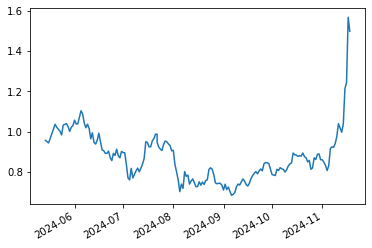

In [30]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [31]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [32]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [33]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT', 'ETCUSDT',
       'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT', 'FLOWUSDT',
       'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT', 'IMXUSDT',
       'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT', 'LTCUSDT', 'MKRUSDT',
       'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT', 'PEPEUSDT', 'QNTUSDT',
       'RAYUSDT', 'RUNEUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT',
       'SUIUSDT', 'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT',
       'VETUSDT', 'WBETHUSDT', 'WBTCUSDT', 'WLDUSDT', 'XECUSDT', 'XLMUSDT',
       'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [34]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [35]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.001},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.001}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
TRXUSDT,0.3799
OMUSDT,0.3133
BNBUSDT,0.1202
PEPEUSDT,0.0914
SUIUSDT,0.0730
RAYUSDT,0.0202
USDCUSDT,0.0010
FDUSDUSDT,0.0010
WBTCUSDT,0.0000
BTCUSDT,0.0000


In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
OMUSDT,0.347683
BTCUSDT,0.300000
TRXUSDT,0.203639
PEPEUSDT,0.072183
SUIUSDT,0.064654
RAYUSDT,0.011841


In [37]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [38]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.674264
OMUSDT,0.227617
BTCUSDT,0.098119


## Real Portfolio vs Optimal

In [39]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1790.602202,0.490965,0.227617,0.263348
BTCUSDT,817.245534,0.224080,0.098119,0.125961
SOLUSDT,423.600933,0.116147,0.000000,0.000000
JASMYUSDT,268.267151,0.073556,0.000000,0.000000
ETHUSDT,214.613337,0.058845,0.000000,0.000000
TRXUSDT,96.932053,0.026578,0.674264,-0.647686
BBUSDT,34.807246,0.009544,0.000000,0.000000
BNBUSDT,1.039869,0.000285,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [40]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1790.602202,0.490965,0.347683,0.143282
BTCUSDT,817.245534,0.224080,0.300000,-0.075920
SOLUSDT,423.600933,0.116147,0.000000,0.000000
JASMYUSDT,268.267151,0.073556,0.000000,0.000000
ETHUSDT,214.613337,0.058845,0.000000,0.000000
TRXUSDT,96.932053,0.026578,0.203639,-0.177061
BBUSDT,34.807246,0.009544,0.000000,0.000000
BNBUSDT,1.039869,0.000285,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.072183,-0.072183
SUIUSDT,0.000000,0.000000,0.064654,0.000000


# Risk Reward Analysis

In [41]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [42]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

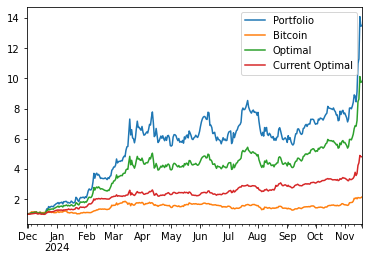

In [43]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [44]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

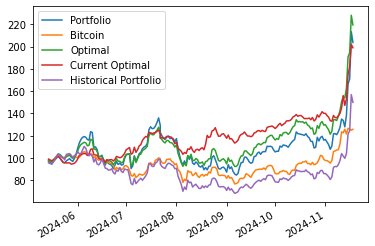

In [45]:
((1+current_perf).cumprod()*100).plot()

In [46]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-09,123.553085,107.396678,137.446606,137.757445,94.008988
2024-11-10,127.419561,112.447898,142.222877,139.926700,97.593964
2024-11-11,134.908004,123.471420,150.486099,144.874935,103.895139
2024-11-12,133.685278,122.498214,154.805554,156.032610,101.831113
2024-11-13,127.900121,125.827540,154.019028,147.208733,99.652329
2024-11-14,138.231759,121.508341,162.509904,152.840149,103.829984
2024-11-15,166.366277,126.559238,190.790921,174.827602,121.306306
2024-11-16,171.025036,125.938840,194.526238,181.960298,124.458738
2024-11-17,213.356181,124.918540,228.116758,201.938629,156.903359
2024-11-18,203.686680,125.761064,219.450123,198.947998,149.917217


## Volatilities

In [47]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.597381
 dtype: float64,
 0.5981937473421856)

In [48]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.675427
 dtype: float64,
 0.6754265692243047)

In [49]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.760815
Bitcoin            0.438897
Optimal            0.598194
Current Optimal    0.414467
dtype: float64

In [50]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.440590573597804

## Risk Contribution

In [51]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.341434,0.300000,0.031661,0.143391,0.048449,0.094942
OMUSDT,18.193682,0.347683,0.915209,0.681391,0.575539,0.105852
PEPEUSDT,0.356588,0.072183,0.021164,0.078185,0.024086,0.054099
RAYUSDT,0.051585,0.011841,0.003131,0.011643,0.000556,0.011087
SUIUSDT,0.152302,0.064654,0.010709,0.043452,0.010780,0.032671
TRXUSDT,0.163567,0.203639,0.018125,0.041939,0.011334,0.030605


In [52]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.595712,0.227617,0.413958,0.524475,0.425247,0.099228
BTCUSDT,0.036812,0.098119,0.067841,0.051006,0.011408,0.039598
TRXUSDT,0.356395,0.674264,0.518201,0.424519,0.332483,0.092036


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.282413,0.49,0.737464,0.749260,0.634716,0.114543
BTCUSDT,0.082540,0.22,0.125880,0.082843,0.018471,0.064372
SOLUSDT,0.044541,0.12,0.068462,0.077327,0.013281,0.064045
JASMYUSDT,-0.012112,0.07,0.024086,0.051908,0.009406,0.042502
ETHUSDT,-0.003447,0.06,0.023530,0.025894,0.002288,0.023606
TRXUSDT,0.015857,0.03,0.019080,0.003755,0.000212,0.003543
BBUSDT,-0.006401,0.01,0.001497,0.009013,0.000367,0.008646


# Value At Risk

## Historical

### Optimal Weights

In [54]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.04581571777074446, -0.06901522944392187)

### Current Weights

In [55]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.048226569488110015, -0.07023128277954202)

In [56]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [57]:
var=historical_var.iloc[row]
var

OMUSDT      -0.031415
BTCUSDT     -0.000570
SOLUSDT     -0.006544
JASMYUSDT   -0.004232
ETHUSDT     -0.001900
TRXUSDT     -0.000133
BBUSDT      -0.002104
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.046898
Name: 2024-06-17 00:00:00, dtype: float64

In [58]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.044548
BTCUSDT     -0.006534
SOLUSDT     -0.007682
JASMYUSDT   -0.005585
ETHUSDT     -0.002494
TRXUSDT     -0.000335
BBUSDT      -0.000932
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068110
dtype: float64

## Parametric

### Optimal Weights

In [59]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.06198246668288026, -0.07944438508452892)

### Current Weights

In [60]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06998502577080551, -0.08970145325020147)

## Multivariate

### Optimal Weights

In [61]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05532535431130591, -0.07018950116693042)

### Current Weights

In [62]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06691179767076169, -0.08427826417870242)

In [63]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.046828
BTCUSDT     -0.006341
SOLUSDT     -0.005430
JASMYUSDT   -0.003569
ETHUSDT     -0.001889
TRXUSDT     -0.000242
BBUSDT      -0.000574
Portfolio   -0.064874
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [64]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.055294774977965325, -0.07170471034082229)

### Current Weights

In [65]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06557745874302358, -0.08443198659179757)

In [66]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.048702
BTCUSDT     -0.004879
SOLUSDT     -0.005227
JASMYUSDT   -0.003160
ETHUSDT     -0.001883
TRXUSDT     -0.000106
BBUSDT      -0.000643
Portfolio   -0.064601
dtype: float64

## Student Copula

### Optimal Weights

In [67]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05419960387444821, -0.0695273737595613)

### Current Weights

In [68]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0670418475326667, -0.08796579838222843)

In [69]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.048686
BTCUSDT     -0.005945
SOLUSDT     -0.005260
JASMYUSDT   -0.003434
ETHUSDT     -0.001976
TRXUSDT     -0.000137
BBUSDT      -0.000647
Portfolio   -0.066085
dtype: float64

## Gumbel Copula

### Optimal Weights

In [70]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.10277870330359606, -0.14660020655398187)

### Current Weights

In [71]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.11869951779253941, -0.17112556645133742)

In [72]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.114604
BTCUSDT     -0.003519
SOLUSDT     -0.000724
JASMYUSDT   -0.002352
ETHUSDT     -0.000201
TRXUSDT      0.000023
BBUSDT      -0.000277
Portfolio   -0.121655
dtype: float64

## Monte Carlo

### Optimal

In [73]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [74]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06307594833928575, -0.08041071963054855)

### Current Weights

In [75]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07028553261631915, -0.08880673355005578)

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.051508
BTCUSDT     -0.006514
SOLUSDT     -0.006131
JASMYUSDT   -0.004286
ETHUSDT     -0.001963
TRXUSDT     -0.000242
BBUSDT      -0.000709
Portfolio   -0.071353
dtype: float64

## VaR Violation

In [77]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.050952,-0.087790,-0.073969,-0.026067
2024-01-15,-0.050952,-0.087779,-0.073195,0.011640
2024-01-16,-0.050952,-0.087376,-0.073822,0.038965
2024-01-17,-0.050952,-0.088762,-0.076157,-0.022622
2024-01-18,-0.050952,-0.091189,-0.078915,-0.035144
...,...,...,...,...
2024-11-15,-0.040884,-0.098668,-0.085478,0.174026
2024-11-16,-0.040884,-0.098441,-0.082948,0.019578
2024-11-17,-0.040884,-0.119149,-0.099552,0.172679
2024-11-18,-0.042799,-0.121020,-0.100905,-0.037992


In [78]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035672,-0.084085,-0.080392,-0.015546
2024-05-29,-0.035672,-0.081562,-0.076156,-0.008440
2024-05-30,-0.035672,-0.070489,-0.067198,0.026906
2024-05-31,-0.035672,-0.071582,-0.065350,0.036505
2024-06-01,-0.035672,-0.074955,-0.069809,0.052949
...,...,...,...,...
2024-11-15,-0.042393,-0.148872,-0.122713,0.203532
2024-11-16,-0.042393,-0.148315,-0.118493,0.028003
2024-11-17,-0.042393,-0.194804,-0.148360,0.247514
2024-11-18,-0.045034,-0.198589,-0.156161,-0.045321


<AxesSubplot:>

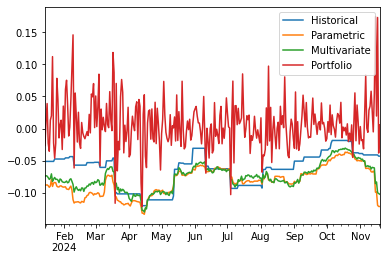

In [79]:
var_data.plot()

<AxesSubplot:>

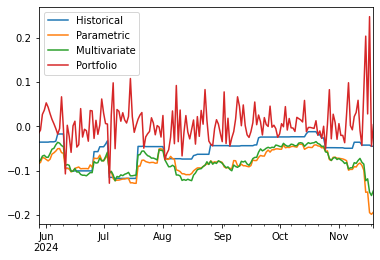

In [80]:
current_var_data.plot()

In [81]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.022508,0.012862,0.012862
Kupiec Stat,6.170968,12.683621,12.683621
P-value,0.012986,0.000369,0.000369


In [82]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.079545,0.017045,0.011364
Kupiec Stat,2.763983,5.342073,7.946462
P-value,0.096408,0.020817,0.004818


# Principal Component Analysis

## Historical PCA

In [83]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77440555, 0.07404517, 0.06302811, 0.04808099, 0.04044018])

In [84]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.015373
ADAUSDT     0.015573
ALGOUSDT    0.017039
APTUSDT     0.016532
ARBUSDT     0.016941
              ...   
WLDUSDT     0.022615
XECUSDT     0.016127
XLMUSDT     0.011060
XRPUSDT     0.010078
XTZUSDT     0.015920
Name: PC1, Length: 62, dtype: float64

<AxesSubplot:>

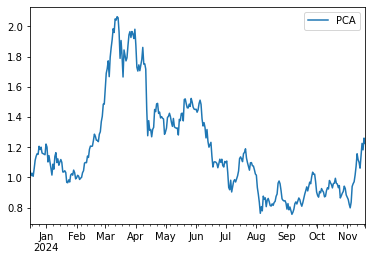

In [85]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

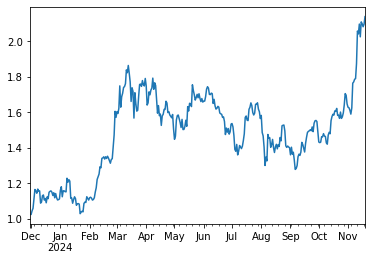

In [86]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [87]:
comparison=historical_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
ETHUSDT      0.380001
WBETHUSDT    0.380028
FLOWUSDT     0.383268
DOTUSDT      0.394272
               ...   
FLOKIUSDT    1.079953
WLDUSDT      1.085022
BONKUSDT     1.087375
PEPEUSDT     1.124129
OMUSDT       1.503259
Length: 63, dtype: float64

<AxesSubplot:>

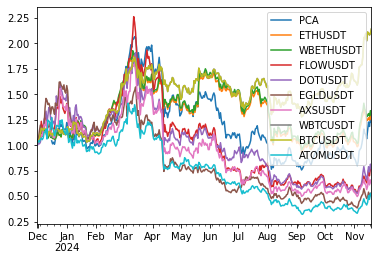

In [88]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

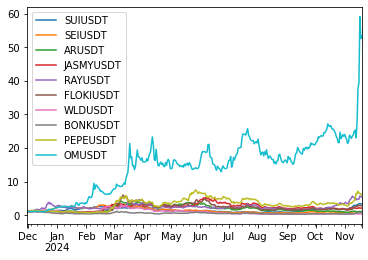

In [89]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [90]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.59683814, 0.17214399, 0.12780962, 0.07252023, 0.03068802])

In [91]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.110972
BTCUSDT      0.066843
SOLUSDT      0.106282
JASMYUSDT    0.152164
ETHUSDT      0.087585
TRXUSDT      0.014252
BBUSDT       0.222145
BNBUSDT      0.065387
PEPEUSDT     0.174370
Name: PC1, dtype: float64

<AxesSubplot:>

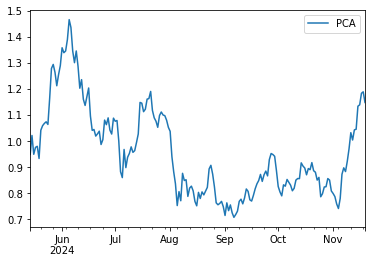

In [92]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

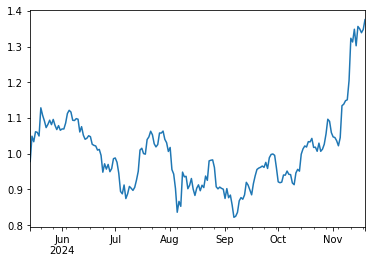

In [93]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [94]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.364561
ETHUSDT      0.365470
BTCUSDT      0.394296
BNBUSDT      0.407271
JASMYUSDT    0.482310
TRXUSDT      0.618446
PEPEUSDT     0.625627
BBUSDT       0.682999
OMUSDT       0.840808
dtype: float64

<AxesSubplot:>

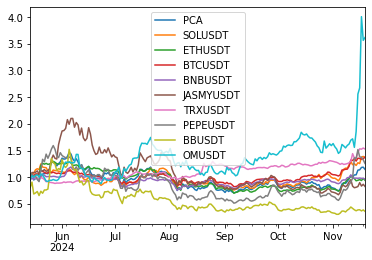

In [95]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [96]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.914652
BBUSDT       1.594812
JASMYUSDT    1.282641
SOLUSDT      1.141724
BTCUSDT      1.000000
ETHUSDT      0.947367
OMUSDT       0.911006
BNBUSDT      0.653830
TRXUSDT      0.260696
Name: BTCUSDT, dtype: float64

In [97]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       1.173473
PEPEUSDT     1.131868
JASMYUSDT    1.076986
BTCUSDT      1.000000
ETHUSDT      0.751647
SOLUSDT      0.750155
BNBUSDT      0.430245
TRXUSDT      0.005819
OMUSDT      -0.425287
Name: BTCUSDT, dtype: float64

## Sliding window optimization

In [98]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,SOLUSDT,JASMYUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.000000,0.150844,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.111977,0.000000,0.000000,0.340265,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [99]:
results={}
window=14
days=90
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,BCHUSDT,...,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XECUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-09-04,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2024-09-18,0.0,0.000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2024-10-02,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2024-10-16,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.057758,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2024-10-30,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2024-11-13,0.0,0.083266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.317862,0.0,0.0
2024-11-19,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [100]:
rolling_optimization.iloc[-3].sort_values(ascending=False)

TRXUSDT      0.647322
DOGEUSDT     0.203815
RAYUSDT      0.110561
FDUSDUSDT    0.038302
AAVEUSDT     0.000000
               ...   
GRTUSDT      0.000000
HBARUSDT     0.000000
ICPUSDT      0.000000
IMXUSDT      0.000000
XTZUSDT      0.000000
Name: 2024-10-30 00:00:00, Length: 62, dtype: float64

<AxesSubplot:>

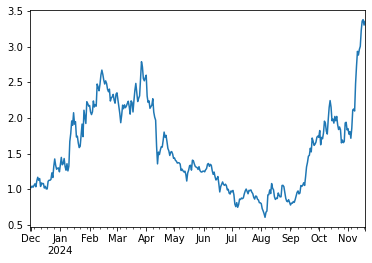

In [101]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()